In [33]:
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import contextily as ctx
from shapely.geometry import Point
from matplotlib.lines import Line2D
import os

ox.settings.log_console = False
ox.settings.use_cache = True

In [12]:
OUTPUT_DIR = "../data/osmnx"
os.makedirs(OUTPUT_DIR, exist_ok=True)

#### Coordinate system transformation + Spatial data preparation


In [13]:
place = "Lahore District, Pakistan"
boundary = ox.geocode_to_gdf(place)  # Get administrative Boundary for Lahore

# Central point
latitude = 31.456845
longitude = 74.407836

gdf = gpd.GeoDataFrame(
    {"geometry": [Point(longitude, latitude)]},
    crs="EPSG:4326",  # WGS84
)

gdf_utm = ox.projection.project_gdf(gdf)  # Convert from global zone to local zone
gdf_utm.to_file(f"{OUTPUT_DIR}/utm-point.gpkg", driver="GPKG")

#### Lahore Plot (Polygon)


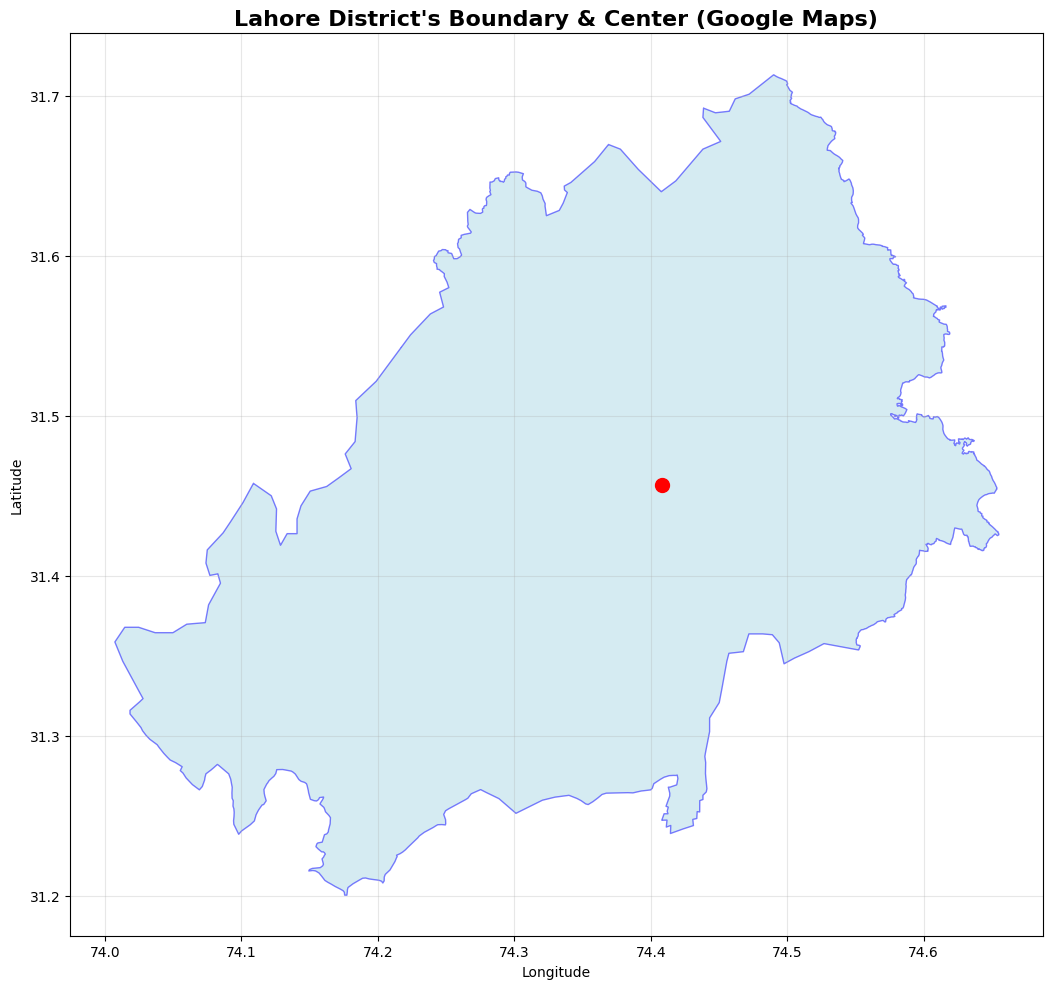

In [14]:
fig, ax = plt.subplots(figsize=(12, 10))

boundary.plot(
    ax=ax, color="lightblue", edgecolor="blue", alpha=0.5, label="Lahore District"
)
gdf.plot(ax=ax, color="red", markersize=100, label="Your Point")

ax.set_title(
    "Lahore District's Boundary & Center (Google Maps)",
    fontsize=16,
    fontweight="bold",
)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [15]:
gdf_utm = gpd.read_file(f"{OUTPUT_DIR}/utm-point.gpkg")
utm_crs = gdf_utm.crs
print("UTM CRS:", utm_crs)

UTM CRS: EPSG:32643


In [16]:
pois = ox.features_from_place(
    place,
    {
        "amenity": ["hospital", "university", "college"],
        "shop": ["supermarket", "mall"],
        "building": ["retail", "commercial"],
    },
)

In [17]:
# Feature engineering and Data Preparation


def filter_pois(df, conditions):
    return df[conditions][["geometry", "name"]].copy()


hospitals = filter_pois(pois, pois["amenity"] == "hospital").assign(type="hospital")
universities = filter_pois(
    pois, pois["amenity"].isin(["university", "college"])
).assign(type="education")

markets = filter_pois(
    pois,
    pois["shop"].isin(["supermarket", "mall"])
    | pois["building"].isin(["retail", "commercial"]),
).assign(type="market")

all_pois = gpd.GeoDataFrame(
    gpd.pd.concat([hospitals, universities, markets]), crs=pois.crs
)

pois = None

In [18]:
all_pois

geometry  \
element id                                                              
node    271105745                            POINT (74.3715 31.47673)   
        526681507                           POINT (74.31162 31.50248)   
        563684371                           POINT (74.34049 31.50868)   
        674141730                           POINT (74.26318 31.49678)   
        1357553198                          POINT (74.29927 31.46985)   
...                                                               ...   
way     1414840359  POLYGON ((74.14252 31.3849, 74.14259 31.38493,...   
        1414840360  POLYGON ((74.1425 31.38493, 74.14257 31.38496,...   
        1414840361  POLYGON ((74.14255 31.38484, 74.14262 31.38487...   
        1414840362  POLYGON ((74.14254 31.38487, 74.14261 31.3849,...   
        1417455185  POLYGON ((74.28042 31.55106, 74.28079 31.55105...   

                                            name      type  
element id                                                  
node    271105745   DHA Medical Center Phase III  hospital  
        526681507               PU Health Center  hospital  
        563684371          یونائیٹڈ کرسچن ہسپتال  hospital  
        674141730       Social Security Hospital  hospital  
        1357553198               Saadan Hospital  hospital  
...                                          ...       ...  
way     1414840359                        Shop 1    market  
        1414840360                        Shop 1    market  
        1414840361                        Shop 1    market  
        1414840362                        Shop 1    market  
        1417455185    Imtiaz Mega Gulshan-e-Ravi    market  

[1191 rows x 3 columns]

In [ ]:
# Convert polygons to points

all_pois.geometry = all_pois.geometry.apply(
    lambda geom: (
        geom.centroid if geom.geom_type in ["Polygon", "MultiPolygon"] else geom
    )
)

In [20]:
all_pois

geometry                          name  \
element id                                                                    
node    271105745    POINT (74.3715 31.47673)  DHA Medical Center Phase III   
        526681507   POINT (74.31162 31.50248)              PU Health Center   
        563684371   POINT (74.34049 31.50868)         یونائیٹڈ کرسچن ہسپتال   
        674141730   POINT (74.26318 31.49678)      Social Security Hospital   
        1357553198  POINT (74.29927 31.46985)               Saadan Hospital   
...                                       ...                           ...   
way     1414840359   POINT (74.14256 31.3849)                        Shop 1   
        1414840360  POINT (74.14254 31.38493)                        Shop 1   
        1414840361   POINT (74.1426 31.38484)                        Shop 1   
        1414840362  POINT (74.14258 31.38487)                        Shop 1   
        1417455185  POINT (74.28061 31.55077)    Imtiaz Mega Gulshan-e-Ravi   

                        type  
element id                    
node    271105745   hospital  
        526681507   hospital  
        563684371   hospital  
        674141730   hospital  
        1357553198  hospital  
...                      ...  
way     1414840359    market  
        1414840360    market  
        1414840361    market  
        1414840362    market  
        1417455185    market  

[1191 rows x 3 columns]

In [21]:
all_pois.to_file(f"{OUTPUT_DIR}/all-pois.gpkg", layer="pois", driver="GPKG")

In [22]:
# all_pois = gpd.read_file(f"{OUTPUT_DIR}/all-pois.gpkg", layer="pois")

In [ ]:
# Extract bus-compatible roads

G = ox.graph_from_polygon(
    boundary.geometry.iloc[0], network_type="drive", truncate_by_edge=True
)

boundary = boundary.to_crs(utm_crs)

BOUNDARY_FPATH = f"{OUTPUT_DIR}/lahore_boundary.gpkg"
if not os.path.exists(BOUNDARY_FPATH):
    print("Saving Lahore's boundary info.")
    boundary.to_file(BOUNDARY_FPATH, driver="GPKG")

all_pois = all_pois.to_crs(utm_crs)
G = ox.project_graph(G, to_crs=utm_crs)

Saving Lahore's boundary info.


In [24]:
ox.save_graphml(G, filepath=f"{OUTPUT_DIR}/network.graphml")

In [25]:
# G = ox.load_graphml(f"{OUTPUT_DIR}/network.graphml")

In [26]:
edges = ox.graph_to_gdfs(G, nodes=False, edges=True)
major_roads = edges[edges["highway"].isin(["primary", "secondary", "trunk"])]

### Visualization


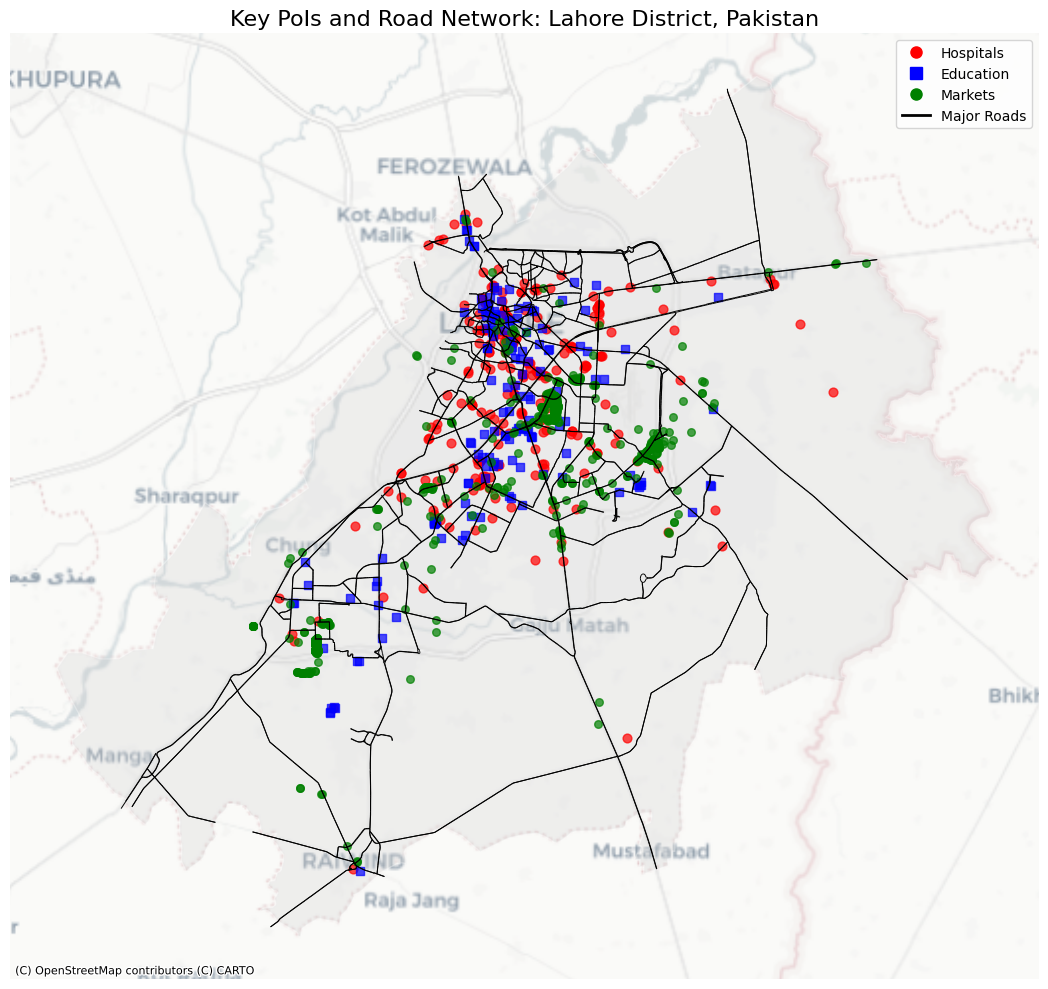

In [27]:
fig, ax = plt.subplots(figsize=(12, 10))

boundary.plot(ax=ax, color="lightgray", edgecolor="white", alpha=0.3)
major_roads.plot(ax=ax, color="black", linewidth=0.7)

poi_colors = {"hospital": "red", "education": "blue", "market": "green"}
for ptype, color in poi_colors.items():
    subset = all_pois[all_pois["type"] == ptype]
    subset.plot(
        ax=ax,
        color=color,
        markersize=30 + 10 * (ptype == "hospital"),
        alpha=0.7,
        marker="o" if ptype != "education" else "s",
    )

ctx.add_basemap(ax, crs=utm_crs, source=ctx.providers.CartoDB.Positron)

legend_elements = [
    Line2D([0], [0], color="red", lw=0, marker="o", markersize=8, label="Hospitals"),
    Line2D([0], [0], color="blue", lw=0, marker="s", markersize=8, label="Education"),
    Line2D([0], [0], color="green", lw=0, marker="o", markersize=8, label="Markets"),
    Line2D([0], [0], color="black", lw=2, label="Major Roads"),
]
ax.legend(handles=legend_elements, loc="upper right")
ax.set_title(f"Key PoIs and Road Network: {place}", fontsize=16)
ax.axis("off")

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/lahore-poi-network.png", dpi=300)
plt.show()

## Points of Interest


In [28]:
print(f"Hospitals: {len(hospitals)}")
print(f"Education Institutions: {len(universities)}")
print(f"Markets: {len(markets)}")
print(f"Total POIs: {len(all_pois)}")
print(f"Road Network: {len(edges)} edges")

Hospitals: 227
Education Institutions: 160
Markets: 804
Total POIs: 1191
Road Network: 378090 edges


In [29]:
# Calculate basic network stats
basic_stats = ox.basic_stats(G)

In [30]:
print("BASIC NETWORK STATISTICS:")
print(f"Number of nodes: {basic_stats['n']}")
print(f"Number of edges: {basic_stats['m']}")
print(f"Total street length: {basic_stats['street_length_total']:,.0f} meters")
print(f"Average street length: {basic_stats['street_length_avg']:.1f} meters")
print(f"Intersection count: {basic_stats['intersection_count']}")

BASIC NETWORK STATISTICS:
Number of nodes: 145131
Number of edges: 378090
Total street length: 17,574,097 meters
Average street length: 88.1 meters
Intersection count: 118202


In [49]:
WORLDPOP_DIR = "../data/worldpop"
WORLDPOP_CSV = f"{WORLDPOP_DIR}/pak_pd_2020_1km_UNadj_ASCII_XYZ.csv"
CLIPPED_GPKG = f"{WORLDPOP_DIR}/worldpop_lahore_rows.gpkg"

if os.path.exists(CLIPPED_GPKG):
    print("Loading existing Lahore population density file.")
    lahore_pop_gdf = gpd.read_file(CLIPPED_GPKG)
else:
    print("Generating Lahore's population density in particular.")
    pk_pop_df = pd.read_csv(WORLDPOP_CSV)

    pk_pop_gdf = gpd.GeoDataFrame(
        pk_pop_df,
        geometry=gpd.points_from_xy(pk_pop_df.X, pk_pop_df.Y),
        crs="EPSG:4326",  # for some godforsaken reason, boundary.crs doesn't work here...
    )

    pk_pop_gdf = pk_pop_gdf.to_crs(boundary.crs)
    lahore_pop_gdf = gpd.clip(pk_pop_gdf, boundary)
    lahore_pop_gdf = lahore_pop_gdf[lahore_pop_gdf["Z"] > 0]

    if len(lahore_pop_gdf) > 0:
        lahore_pop_gdf.to_file(CLIPPED_GPKG, driver="GPKG")
        print(f"Saved clipped data to {CLIPPED_GPKG}")
    else:
        print("Warning: No valid population data found in Lahore boundary.")

lahore_pop_gdf = lahore_pop_gdf.to_crs(utm_crs)

Loading existing Lahore population density file.


In [ ]:
lahore_pop_gdf = lahore_pop_gdf.rename(
    columns={"X": "longitude", "Y": "latitude", "Z": "population"}
)

lahore_pop_gdf.head(3)

   longitude   latitude  population                        geometry
0  74.202916  31.212083  746.548706  POINT (424073.354 3453380.183)
1  74.194583  31.212083  612.143555  POINT (423279.534 3453385.936)
2  74.186250  31.212083  733.004272  POINT (422485.712 3453391.749)
      longitude   latitude   population                        geometry
2434  74.119583  31.445417  1274.122437  POINT (416341.756 3479302.336)
2435  74.111250  31.445417  1569.775879  POINT (415549.884 3479308.714)
2436  74.102916  31.445417  1748.885620  POINT (414758.011 3479315.153)
